### Imports Libs

In [36]:
import os
from pathlib import Path
import matplotlib.pyplot as plt
import shutil
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np
from tensorflow.keras.preprocessing import image
from mtcnn import MTCNN
import cv2
import warnings
warnings.filterwarnings("ignore")


### Load Data :

In [14]:
Data_URL = '../../../deeplearning/data/global_data/UTKFace'
if os.path.exists(Data_URL):
    race_labes = []
    items = os.listdir(Data_URL)
    for item in items:
        race_labes.append(item.split('_')[2]) 
else :
    print('No Path !!!')

### check unique labels :

In [15]:
for i in race_labes:
    if len(i) > 1:
        race_labes.remove(i)

unique_labels = set(race_labes)

unique_labels

{'0', '1', '2', '20170109150557335.jpg.chip.jpg', '3', '4'}

### Create Folder race_data :

In [16]:
folder_path = "../../../deeplearning/data/race_data"
p = Path(folder_path)

if p.is_dir():
    print(f"The folder '{folder_path}' exists.")
else:
    os.mkdir(folder_path)
    print(f"The folder '{folder_path}' is created ")



The folder '../../../deeplearning/data/race_data' exists.


### Display foreach label 4 images :

Label 0:


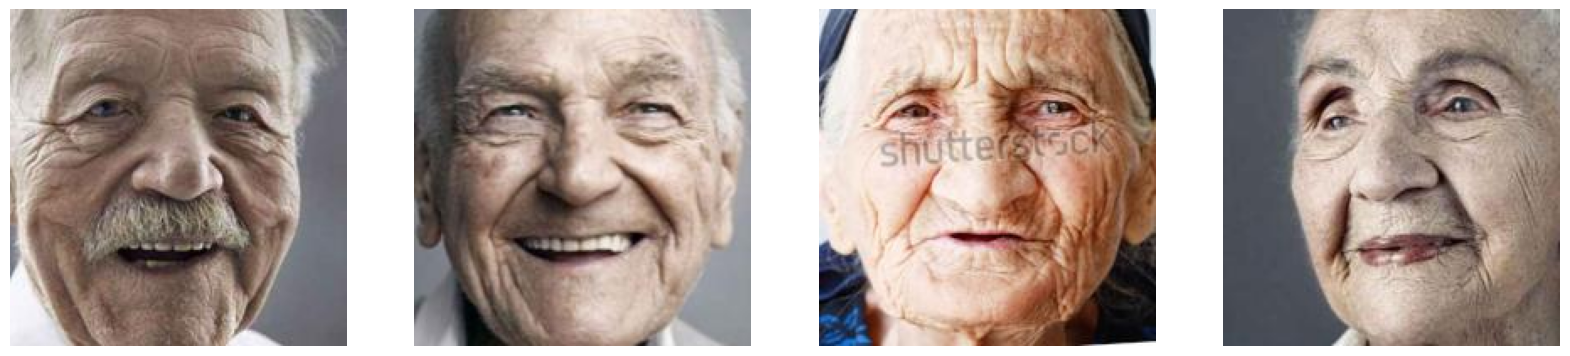

Label 1:


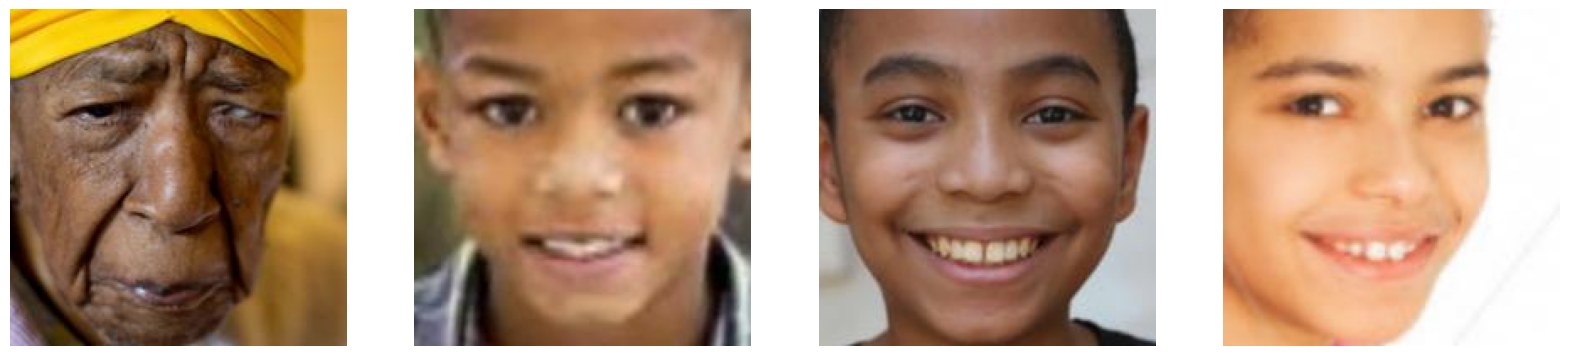

Label 2:


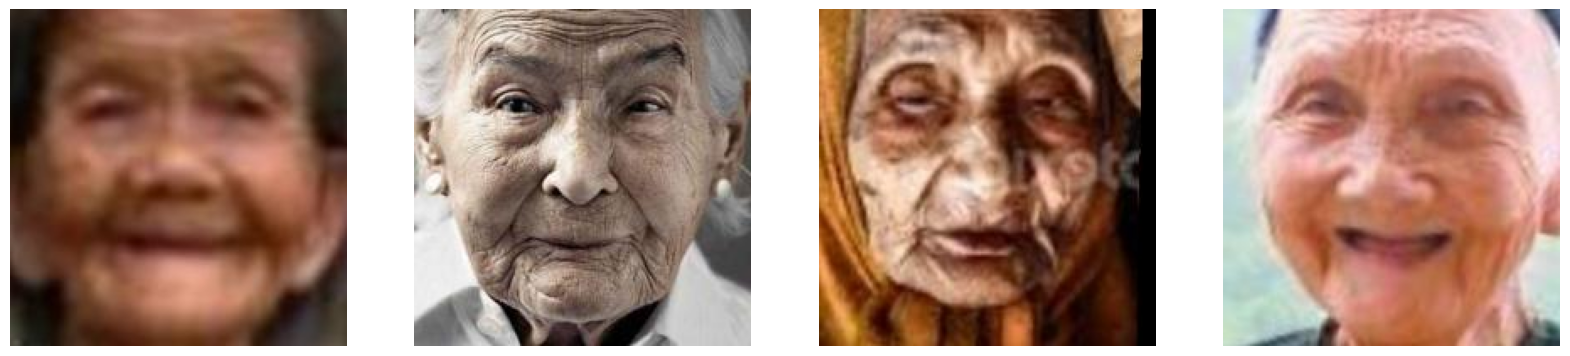

Label 3:


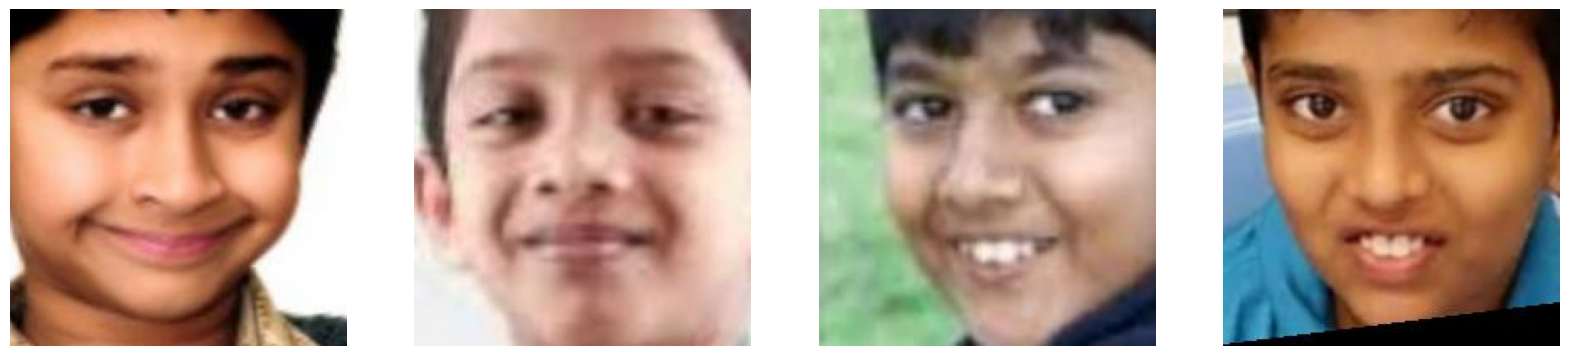

Label 4:


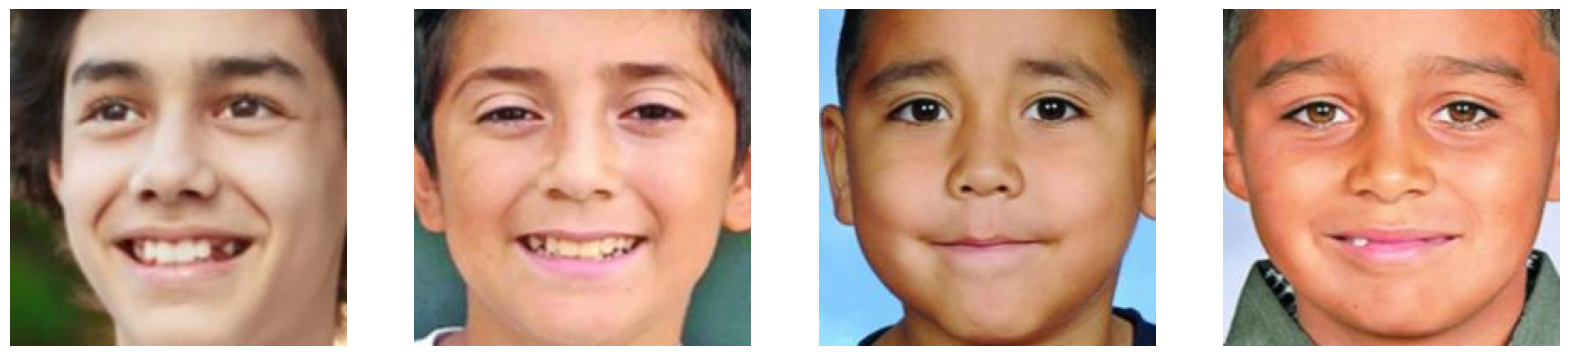

In [17]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg


label_images = { "0": [], "1": [], "2": [], "3": [], "4": [] }

for item in items:
    race = item.split('_')[2]

    if race in label_images and len(label_images[race]) < 4:
        label_images[race].append(item)
    
# Display the images
for label, imgs in label_images.items():
    print(f"Label {label}:")

    plt.figure(figsize=(20, 5))
    for i, img_name in enumerate(imgs):
        img = mpimg.imread(f"{Data_URL}/{img_name}")
        plt.subplot(1, 4, i+1)
        plt.imshow(img)
        plt.axis("off")
    plt.show()


### Add Classe Names :

In [18]:
class_names = {"0" : "White", "1": "Black", "2": "Asian", "3": "Indian", "4": "Other"}

### Create Target folders with images :

In [19]:
for o in items:
    Split_name = o.split('_')
    if len(Split_name) == 4 :
        num = Split_name[2]
        os.makedirs(f"{folder_path}/{num}", exist_ok=True)
        source = f"../../../deeplearning/data/global_data/UTKFace/{o}"
        destination = f"{folder_path}/{num}"
        shutil.copy(source,destination)


### Check Total Of Images : 

In [20]:
Total = 0
for a in range(5):
    it= os.listdir(f"{folder_path}/{a}")
    Total += len(it)

print(Total)
print(len(items))


23705
23708


### change folders names :

In [21]:
for old_name, new_name in class_names.items():
    old_path = os.path.join(folder_path, old_name)
    new_path = os.path.join(folder_path, new_name)

    if os.path.exists(old_path):
        os.rename(old_path, new_path)
        print(f"Renamed : {old_name} -> {new_name}")
    else:
        print(f"No folder : {old_name}")

Renamed : 0 -> White
Renamed : 1 -> Black
Renamed : 2 -> Asian
Renamed : 3 -> Indian
Renamed : 4 -> Other


### get data use tensorflow :

In [22]:
Data = tf.keras.utils.image_dataset_from_directory(folder_path, batch_size=32, image_size=(48, 48))
CN = Data.class_names
CN

Found 23705 files belonging to 5 classes.


['Asian', 'Black', 'Indian', 'Other', 'White']

### Display Some Images :

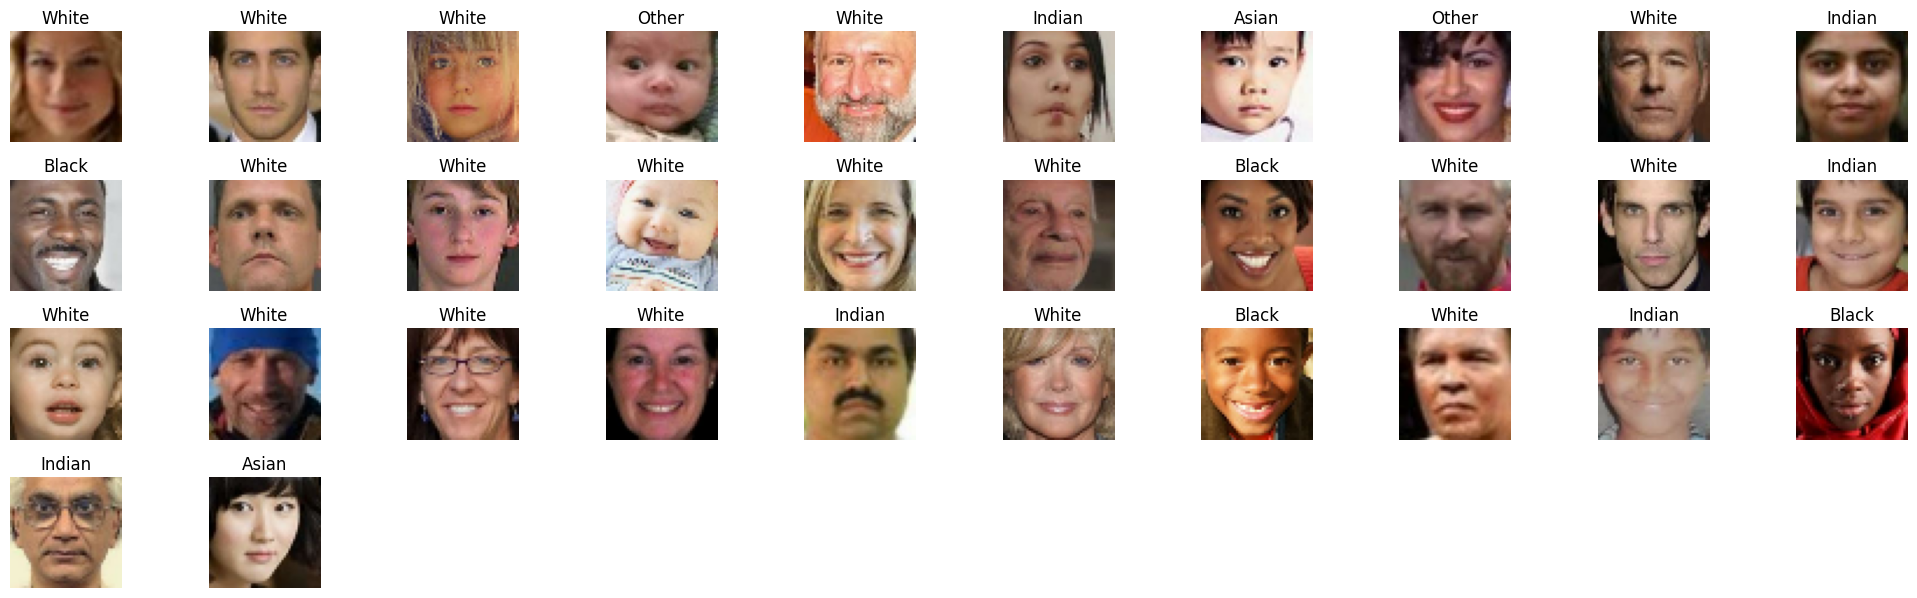

In [23]:
plt.figure(figsize=(20, 15))
for images,labels in Data.take(1):
    for i in range(len(images)):
        plt.subplot(10, 10, i+1)
        img = images[i].numpy()
        img = img.astype(np.uint8)
        plt.imshow(img)
        plt.title(f"{CN[labels[i].numpy()]}")
        plt.axis("off")

plt.tight_layout()
plt.show()

### Split data fro validationtion and trained data : 

In [24]:
train_data = tf.keras.utils.image_dataset_from_directory(
    folder_path,
    validation_split=0.2,   
    subset="training",
    seed=123,               
    batch_size=32,
    image_size=(48, 48)
)

val_data = tf.keras.utils.image_dataset_from_directory(
    folder_path,
    validation_split=0.2,
    subset="validation",
    seed=123,
    batch_size=32,
    image_size=(48, 48)
)


Found 23705 files belonging to 5 classes.
Using 18964 files for training.
Found 23705 files belonging to 5 classes.
Using 4741 files for validation.


### Preparation Data :

In [25]:
def preprocecss(imag, label):
    label = tf.cast(label, tf.int32)
    label = tf.one_hot(label, depth=5)
    return imag, label

train_data = train_data.map(preprocecss)
val_data = val_data.map(preprocecss)

### Check if data normalized and transfer to onhot encoder :

In [26]:
for img, lab in train_data.take(1):
    print(lab)

tf.Tensor(
[[1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 1. 0.]
 [0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0.]
 [0. 1. 0. 0. 0.]], shape=(32, 5), dtype=float32)


### Data Augmentation :

In [27]:
augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    # Random rotation (up to ±20 degrees)
    layers.RandomRotation(0.2),
    # Random zoom (up to ±20%)
    layers.RandomZoom(0.2),
    # Random translation (shift)
    layers.RandomTranslation(height_factor=0.1, width_factor=0.1),
    # Random contrast adjustment
    layers.RandomContrast(0.1),
    # Random brightness adjustment
    layers.RandomBrightness(factor=0.1),
])

### Creation Model layers:

In [28]:
model = models.Sequential()
model.add(augmentation)
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(48, 48, 3)))
model.add(layers.MaxPooling2D((2 ,2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2 ,2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(5, activation='softmax'))

d:\age-gender-race-prediction\venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


### Model Compile :

In [29]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.CategoricalCrossentropy(), 
    metrics=['accuracy']
)

### Add ErlyStoping :

In [30]:


early_stop = EarlyStopping(
    monitor='val_loss',     
    patience=5,                
    restore_best_weights=True 
)



### Fit model :

In [31]:
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs = 50,
    callbacks=[early_stop]
)

Epoch 1/50
593/593 ━━━━━━━━━━━━━━━━━━━━ 25s 38ms/step - accuracy: 0.4289 - loss: 1.7028 - val_accuracy: 0.4853 - val_loss: 1.3777
Epoch 2/50
593/593 ━━━━━━━━━━━━━━━━━━━━ 21s 36ms/step - accuracy: 0.4484 - loss: 1.3952 - val_accuracy: 0.4583 - val_loss: 1.4144
Epoch 3/50
593/593 ━━━━━━━━━━━━━━━━━━━━ 21s 36ms/step - accuracy: 0.4630 - loss: 1.3700 - val_accuracy: 0.5035 - val_loss: 1.3362
Epoch 4/50
593/593 ━━━━━━━━━━━━━━━━━━━━ 22s 36ms/step - accuracy: 0.4731 - loss: 1.3387 - val_accuracy: 0.5267 - val_loss: 1.2518
Epoch 5/50
593/593 ━━━━━━━━━━━━━━━━━━━━ 22s 37ms/step - accuracy: 0.4930 - loss: 1.2989 - val_accuracy: 0.5132 - val_loss: 1.2983
Epoch 6/50
593/593 ━━━━━━━━━━━━━━━━━━━━ 21s 36ms/step - accuracy: 0.5030 - loss: 1.2844 - val_accuracy: 0.5490 - val_loss: 1.1964
Epoch 7/50
593/593 ━━━━━━━━━━━━━━━━━━━━ 22s 37ms/step - accuracy: 0.5126 - loss: 1.2607 - val_accuracy: 0.5476 - val_loss: 1.2140
Epoch 8/50
593/593 ━━━━━━━━━━━━━━━━━━━━ 21s 36ms/step - accuracy: 0.5206 - loss: 1.2533 - 

### Save Model :

In [32]:
model.save('../../models/race_pred.keras')

### Load Model :

In [33]:
My_model = tf.keras.models.load_model('../../models/race_pred.keras')

In [34]:
img_path = "../../../image.png"   

img = image.load_img(img_path, target_size=(48, 48)) 
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0) 

prediction = model.predict(img_array)


pred_class = np.argmax(prediction)

print(CN[pred_class])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
Black


In [45]:

img_path = "../../../image copy 3.png"
img = cv2.imread(img_path)
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  

detector = MTCNN()

result = detector.detect_faces(img_rgb)

for face in result:
    x, y, w, h = face['box']

    cv2.rectangle(img, (x, y), (x + w, y + h), (255, 255, 255), 2)

    face_crop = img_rgb[y:y+h, x:x+w]

    face_resized = cv2.resize(face_crop, (48, 48)) 
    face_resized = face_resized / 255.0
    face_resized = np.expand_dims(face_resized, axis=0)

    prediction = model.predict(face_resized)
    pred_class = np.argmax(prediction)

    cv2.putText(img,str(CN[pred_class]), (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 204, 255), 2, cv2.LINE_AA)


    print("Prediction:", CN[pred_class])

cv2.imshow("Detected Faces", img)
cv2.waitKey(0)
cv2.destroyAllWindows()


Exception ignored in: <_io.BufferedReader>
Traceback (most recent call last):
  File "d:\age-gender-race-prediction\venv\Lib\site-packages\lz4\frame\__init__.py", line 753, in flush
    self._fp.flush()
ValueError: I/O operation on closed file.
Exception ignored in: <_io.BufferedReader>
Traceback (most recent call last):
  File "d:\age-gender-race-prediction\venv\Lib\site-packages\lz4\frame\__init__.py", line 753, in flush
    self._fp.flush()
ValueError: I/O operation on closed file.
Exception ignored in: <_io.BufferedReader>
Traceback (most recent call last):
  File "d:\age-gender-race-prediction\venv\Lib\site-packages\lz4\frame\__init__.py", line 753, in flush
    self._fp.flush()
ValueError: I/O operation on closed file.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Prediction: White
